In [1]:
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
#LOAD LIBRARIES 
library(gtools);
library("GenomicRanges");
options(warn=-1)
library(ggplot2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



In [2]:
#SETTING PATH 
pathRNAseq="/sharedFolder/Data/2_RNA_seq/"
results="/sharedFolder/Results/Sequencing"
previousResults="/sharedFolder/Results/Hotspot/"
pathAtacSeq=pathRNAseq

In [3]:
dir.create(results,recursive=TRUE)
results="/sharedFolder/Results/Sequencing/RNA-seq"
dir.create(results,recursive=TRUE)


In [4]:
gtf=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
gtf=gtf[grep("Ligase",gtf[,6]),]
a=list.files(pathAtacSeq,pattern=".bedgraph",recursive=TRUE)
uu=grep("sorted",a)
if(length(uu)!=0){
a=a[-uu]
    }
a=mixedsort(a)
a2=sapply(a,FUN=function(x){strsplit(x,".bedgraph")[[1]][1]})
AtacSeq_count=matrix(0,ncol=length(unique(gtf[,7])),nrow=length(a2))
colnames(AtacSeq_count)=sapply(unique(gtf[,7]),FUN=toString)
rownames(AtacSeq_count)=a2
AtacSeq_rpm=AtacSeq_count
for(j in a){
    system(paste("echo",j))
temp=read.table(paste(pathAtacSeq,"/",j,sep=""),sep="\t")
tempGG=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])),mcols=abs(as.numeric(temp[,4])))
    for(i in seq(nrow(gtf))){
        system(paste("echo",i/nrow(gtf)))
        gg=GRanges(seqnames=as.matrix(gtf[i,1]),ranges=IRanges(start = as.numeric(gtf[i,2]),end=as.numeric(gtf[i,3])))    
        over=findOverlaps(gg,tempGG)@to    
        name=as.vector(noExt((j)))
        AtacSeq_count[name,toString(gtf[i,7])]= sum(tempGG[over]$mcols)
        AtacSeq_rpm[name,toString(gtf[i,7])]= (sum(tempGG[over]$mcols)/sum(abs(temp[,4])))*1000000

   }

}
#write.table((t(AtacSeq_count)),paste(results,"/RNA_AID_Heatmap_count.csv",sep=""),col.names=NA,sep=",")
#write.table((t(AtacSeq_rpm)),paste(results,"/RNA_AID_Heatmap_RPM.csv",sep=""),col.names=NA,sep=",")


In [4]:
results

[1] "/sharedFolder/Results/Sequencing/RNA-seq"

[1] "RAW"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 3.114543e-20 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 5.864267e-24 


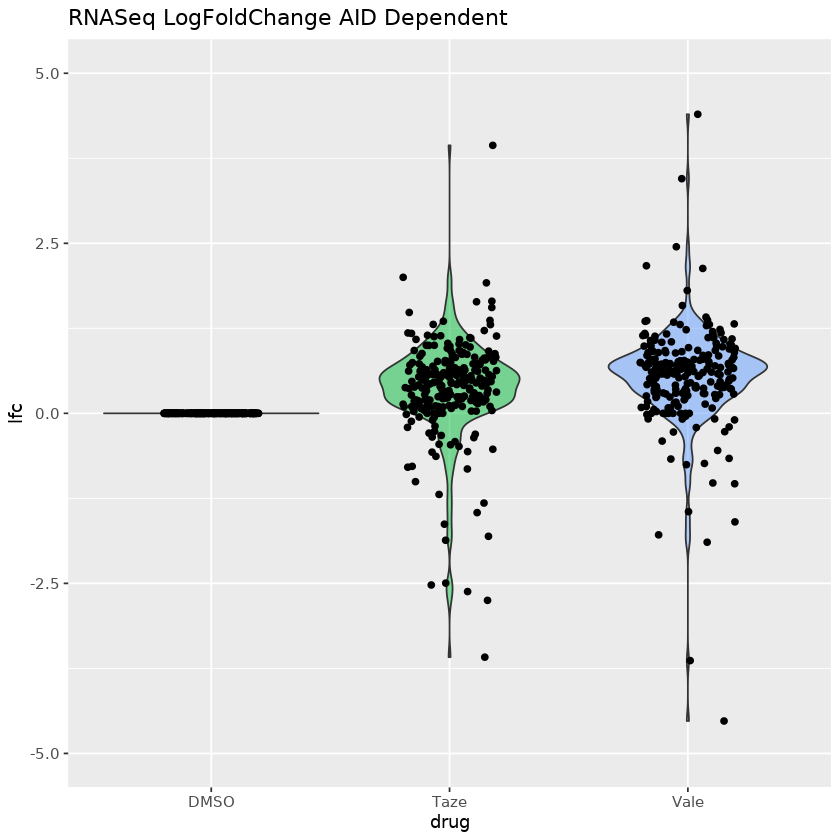

In [6]:
print("RAW")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/RNA_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-5,5) + ggtitle("RNASeq LogFoldChange AID Dependent")
plot(pp)   


condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

[1] "RAW Common "
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 5.118524e-15 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 3.673214e-18 


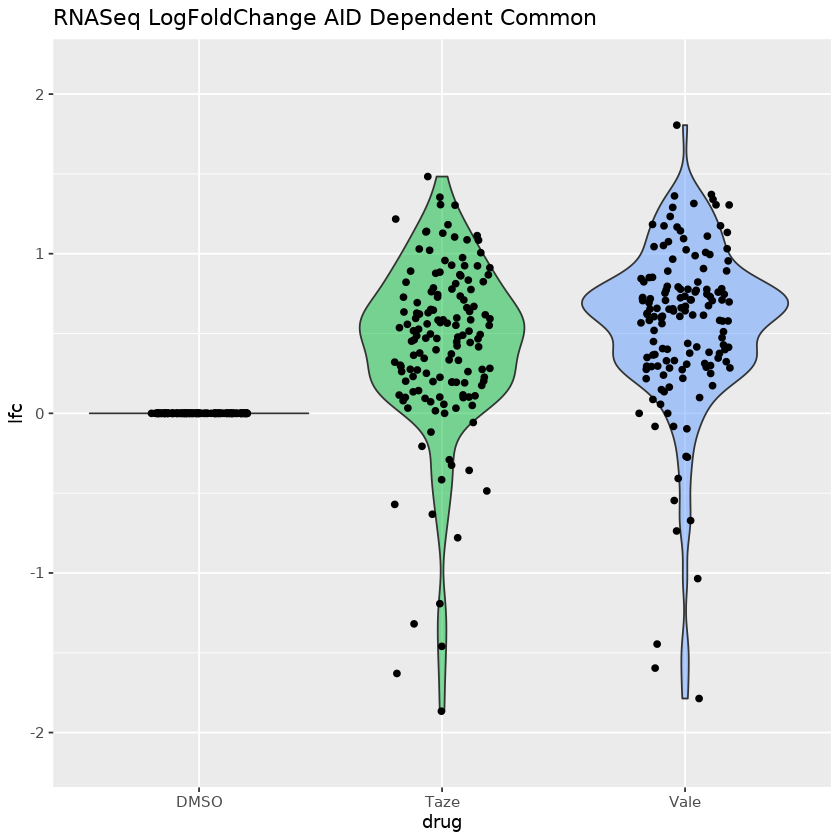

In [7]:
print("RAW Common ")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/RNA_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("RNASeq LogFoldChange AID Dependent Common")
plot(pp)   

condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

[1] "filtered"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 4.908868e-05 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 2.340758e-07 


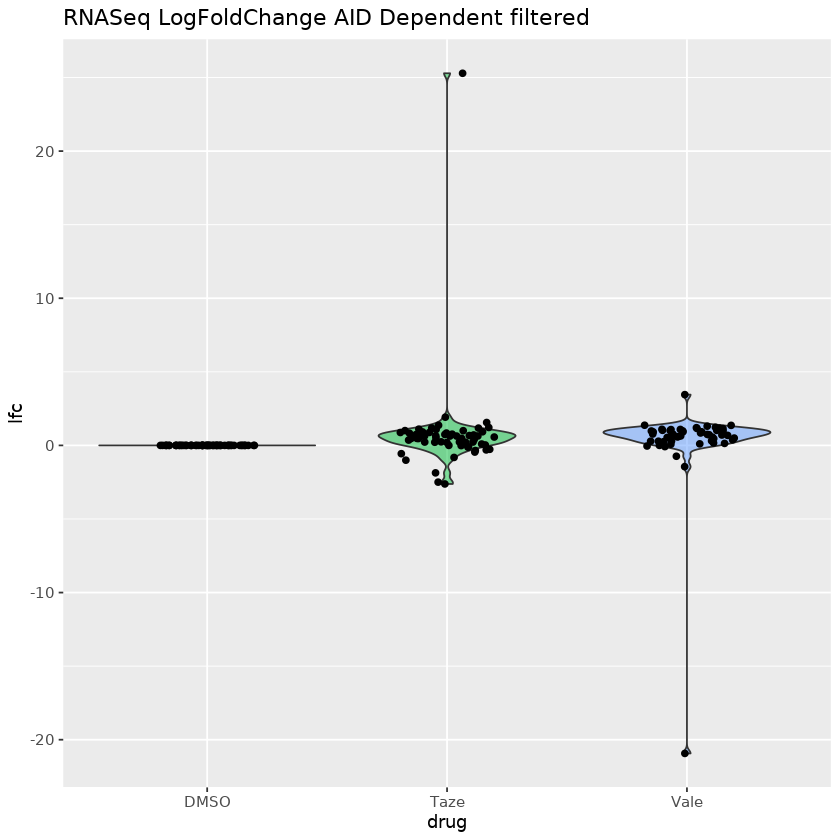

In [ ]:
print("filtered")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/RNA_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-5,5) + ggtitle("RNASeq LogFoldChange AID Dependent filtered")
plot(pp)   

condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

In [13]:
#geneWide
#data=a[sapply(c(TazeSpec,TazVale,ValeSpec,common,TazDMSO,DMSOVale,DMSOSpec),toString),]
#data2=read.table(paste(results,"/count_hgtgtsHeatmap.csv",sep=""),header=TRUE,row.names=1,sep=",")
#data=data2[rownames(data),]
data=log2(as.matrix(read.table(paste(results,"/RNA_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))+1)
condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")


P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 4.908868e-05 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 2.340758e-07 


[1] "filtered Common"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 0.0002148151 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 0.0004298687 


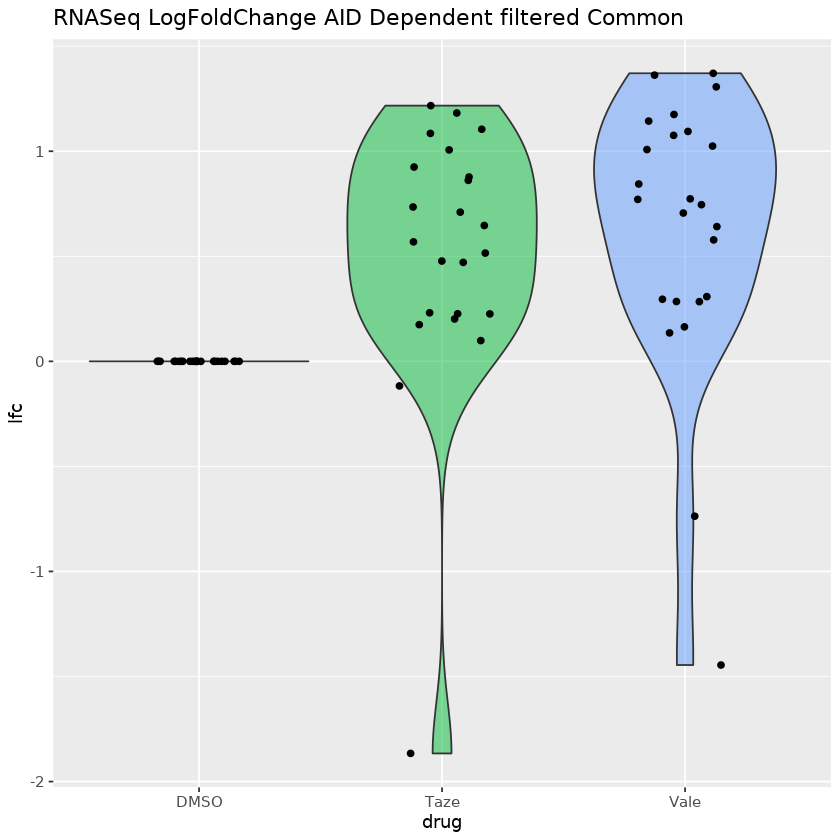

In [9]:
print("filtered Common")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/RNA_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ggtitle("RNASeq LogFoldChange AID Dependent filtered Common")
plot(pp)   

condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

In [10]:
#RPM!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

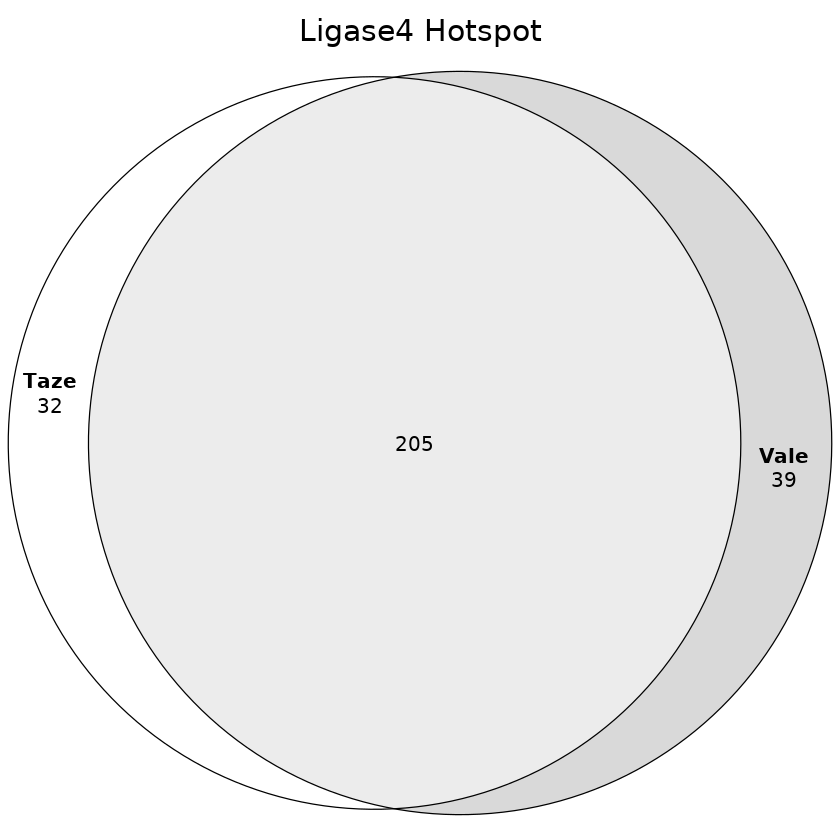

In [1]:
library(eulerr)
fit1 <- euler(c("Taze" = 32,"Vale" = 39,"Taze&Vale"= 205))
plot(fit1,quantities = TRUE,main="Ligase4 Hotspot")

In [13]:
conditions=c("TazeVSDMSO","ValeVSDMSO")
DeGenes=c()
for(i in conditions){
a=read.table(paste(pathRNAseq,"/",i,"/_log2TPM.txt",sep=""),header=TRUE,row.names=1,sep="\t")
b=read.table(paste(pathRNAseq,"/",i,"/DEfiltered_log2fc_1_fdr_0.1.txt",sep=""),header=TRUE,row.names=1,sep="\t")
write.table(a[rownames(b),],paste(results,"/",i,"_heatmap_TPM.csv",sep=""),col.names=NA,sep=",")
DeGenes=append(DeGenes,rownames(b))
}
DeGenes=unique(DeGenes)
a=read.table(paste(pathRNAseq,"/_log2TPM.txt",sep=""),header=TRUE,row.names=1,sep="\t")
write.table(a[DeGenes,],paste(results,"/_heatmap_TPM.csv",sep=""),col.names=NA,sep=",")


In [69]:
intersect_tolower <- function(x, y) {
  x_lower <- tolower(x)
  y_lower <- tolower(y)
  return(intersect(x_lower, y_lower))
}
conditions=c("TazeVSDMSO","ValeVSDMSO")
DeGenes=list()
count=1
for(i in conditions){
b=read.table(paste(pathRNAseq,"/",i,"/DEfiltered_log2fc_1_fdr_0.1.txt",sep=""),header=TRUE,row.names=1,sep="\t")

DeGenes[[count]]=sapply(rownames(b),function(x){
strsplit(x,":")[[1]][1]
})
count=count+1
}
gtf=read.table(paste(previousResults,"Database_annotated.csv",sep="/"),header=TRUE,sep=",")


gtf2=gtf[grep("Ligase",gtf[,6]),]
names= c("Taze","Vale")
for(i in c(1,2)){
gtf3=gtf2[grep(names[i],gtf[,6]),]
print(intersect_tolower(gtf3[,8],DeGenes[[i]]))
    
}

[1] "pappa2" "fcer2a"
[1] "fcer2a"


character(0)


[1] "857" "804" "451" "460" "564" "673" "682" "888" "434" "790" "724" "807"
 [13] "840" "820" "691" "378" "366" "848" "730" "830" "707" "563" "578" "756"
 [25] "549" "526" "894" "747" "918" "681" "435" "720" "861" "759" "909" "869"
 [37] "907" "744" "474" "773" "740" "713" "873" "599" "703" "849" "410" "634"
 [49] "701" "715" "735" "912" "534" "858" "368" "791" "801" "462" "829" "825"
 [61] "796" "914" "781" "422" "645" "503" "719" "631" "903" "758" "732" "906"
 [73] "797" "625" "596" "522" "535" "826" "810" "859" "709" "870" "779" "539"
 [85] "698" "490" "845" "838" "874" "866" "878" "893" "882" "885" "734" "637"
 [97] "823" "766" "892" "898" "651" "704" "648" "433" "787" "854" "895" "367"
[109] "811" "863" "883" "817" "633" "831" "754" "493" "795" "727" "905" "879"
[121] "805" "833" "821" "800" "710" "856" "725" "908" "868" "538" "716" "708"
[133] "693" "764" "899" "626" "478" "685" "729" "855" "880" "489" "532" "877"
[145] "767" "808" "731" "786" "770" "327" "582" "851" "728" "566" "818" "852"
[157] "911" "822" "802" "760" "841" "782" "850" "837" "806" "567" "694" "705"
[169] "453" "774" "884" "846" "726" "886" "881" "498" "803" "762" "706" "772"
[181] "836" "844" "827" "780" "784" "737" "916" "809" "752" "504" "867" "775"
[193] "910" "853" "530" "501" "400" "816" "733" "917" "812" "896" "659" "590"
[205] "794" "702" "913" "813" "901" "814" "358" "717" "789" "835" "872" "609"
[217] "751" "792" "638" "557" "891" "904" "472" "793" "769" "815" "722" "718"
[229] "742" "864" "674" "798" "897" "832" "755" "875" "902" "768" "714" "746"
[241] "513" "771" "785" "842" "761" "889" "653" "865" "860" "748" "723" "876"
[253] "843" "788" "824" "595" "819" "862" "776" "890" "777" "871" "738" "765"
[265] "847" "712" "783" "736" "799" "919" "753" "749" "743" "745" "739" "915"
[277] "695" "417" "471" "741" "828" "757" "763" "711" "642"

In [20]:
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
library("pheatmap")
results="/sharedFolder/"
results2="/sharedFolder/Results/Sequencing/RNA-seq"
previousResults="/sharedFolder/Results/Hotspot/"
library("ggVennDiagram");
library("ggplot2")
library("vioplot")
library(eulerr)
f="TazeFiltered"#result name
cutTagMet_newrpm=as.matrix(read.table(paste(results2,"/RNA_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))+1

In [21]:
Database=unique(read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")[,c(1,2,3,7)])
Taze=rownames(cutTagMet_newrpm)[sort(log2((cutTagMet_newrpm[,2]/cutTagMet_newrpm[,1])),index.return=TRUE)$ix]

rownames(Database)=Database[,4]
DBTU=Database[Taze,]

rmarkdown=matrix(ncol=1)
rmarkdown=rbind(rmarkdown,"---")
rmarkdown=rbind(rmarkdown,'title: "Hotspots"')
rmarkdown=rbind(rmarkdown,"---")
#write batch file 
batch=matrix(ncol=1)




for(i in seq(1,nrow(DBTU))){
temp=(DBTU[i,3]-DBTU[i,2])*2
batch=rbind(batch,paste("goto ",DBTU[i,1],":",(DBTU[i,2]-temp),"-",(DBTU[i,3]+temp),sep=""))
batch=rbind(batch,paste("snapshot ",i,".png",sep=""))


johnTemp=" "
    
rmarkdown=rbind(rmarkdown,paste("## ",rownames(DBTU)[i],sep=""))
rmarkdown=rbind(rmarkdown,paste("![",johnTemp,"](./",i,".png",")",sep=""))
rmarkdown=rbind(rmarkdown," ")

}
batch=batch[-1,]
write.table(batch,paste(results,"/",f,".batch",sep=""),col.names=FALSE,row.names=FALSE,sep="\t",quote=FALSE)
rmarkdown=rmarkdown[-1,]
write.table(rmarkdown,paste(results,"/",f,".rmd",sep=""),row.names=FALSE,col.names=FALSE,quote=FALSE)

In [22]:
f="ValeFiltered"#result name
Database=unique(read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")[,c(1,2,3,7)])
Taze=rownames(cutTagMet_newrpm)[sort(log2((cutTagMet_newrpm[,3]/cutTagMet_newrpm[,1])),index.return=TRUE)$ix]

rownames(Database)=Database[,4]
DBTU=Database[Taze,]

rmarkdown=matrix(ncol=1)
rmarkdown=rbind(rmarkdown,"---")
rmarkdown=rbind(rmarkdown,'title: "Hotspots"')
rmarkdown=rbind(rmarkdown,"---")
#write batch file 
batch=matrix(ncol=1)




for(i in seq(1,nrow(DBTU))){
temp=(DBTU[i,3]-DBTU[i,2])*2
batch=rbind(batch,paste("goto ",DBTU[i,1],":",(DBTU[i,2]-temp),"-",(DBTU[i,3]+temp),sep=""))
batch=rbind(batch,paste("snapshot ",i,".png",sep=""))


johnTemp=" "
    
rmarkdown=rbind(rmarkdown,paste("## ",rownames(DBTU)[i],sep=""))
rmarkdown=rbind(rmarkdown,paste("![",johnTemp,"](./",i,".png",")",sep=""))
rmarkdown=rbind(rmarkdown," ")

}
batch=batch[-1,]
write.table(batch,paste(results,"/",f,".batch",sep=""),col.names=FALSE,row.names=FALSE,sep="\t",quote=FALSE)
rmarkdown=rmarkdown[-1,]
write.table(rmarkdown,paste(results,"/",f,".rmd",sep=""),row.names=FALSE,col.names=FALSE,quote=FALSE)